In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from time import time

In [2]:
from pandas import ewma, DataFrame, Series

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

In [5]:
torch.__version__

'0.4.0'

In [6]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [7]:
torch.cuda.set_device(9)

In [8]:
device = torch.device('cuda' if USE_CUDA else 'cpu')

In [9]:
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

In [10]:
batch_size = 100
original_width, original_height = 28, 28
width, height = 48, 48

In [11]:
kwargs = {'num_workers': 0, 'pin_memory': True} if USE_CUDA else {}

dataset = MNIST

train_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=True, download=True, transform=transforms.Compose([
            transforms.RandomChoice(
                [transforms.Pad((i, 0, width-original_width-i, 0)) for i in range(width-original_width+1)]
            ),
            transforms.RandomChoice(
                [transforms.Pad((0, i, 0, height-original_height-i)) for i in range(height-original_height+1)]
            ),
            transforms.ToTensor()
        ])
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=False, download=True, transform=transforms.Compose([
            transforms.RandomChoice(
                [transforms.Pad((i, 0, width-original_width-i, 0)) for i in range(width-original_width+1)]
            ),
            transforms.RandomChoice(
                [transforms.Pad((0, i, 0, height-original_height-i)) for i in range(height-original_height+1)]
            ),
            transforms.ToTensor()
        ])
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

In [12]:
np.random.seed(123)

train_data = train_loader.dataset.train_data.numpy()
padded_train_data = []
for i in range(train_data.shape[0]):
    right_pad = np.random.choice(width - original_width + 1)
    bottom_pad = np.random.choice(height - original_height + 1)
    padded_train_data.append(np.pad(
        train_data[i], 
        pad_width=((width-original_width-right_pad, right_pad), (height-original_height-bottom_pad, bottom_pad)),
        mode='constant'
    ))
padded_train_data = np.array(padded_train_data)

In [13]:
padded_train_data_loader = torch.utils.data.DataLoader(
    TensorDataset(
        torch.from_numpy(padded_train_data).float() / 255, 
        train_loader.dataset.train_labels
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

In [14]:
print(train_loader.dataset.train_data.shape)
print(test_loader.dataset.test_data.shape)
print(padded_train_data_loader.dataset.tensors[0].shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000, 48, 48])


In [15]:
input_shape = [1, height, width]
output_size = 10

**VAE**

In [19]:
def binary_crossentropy_loss(x_true, x_distr):
    """
    Вычисляет бинарную кроссэнтропию между эмприческим распределением на данные
    и индуцированным моделью распределением, т. е. правдоподобие объектов x_true.
    Каждому объекту из x_true соответствуют K сэмплированных распределений
    на x из x_distr.
    i-му объекту соответствуют распределения с номерами i * K, ..., (i + 1) * K - 1.
    Требуется вычислить оценку логарифма правдоподобия для каждого объекта.
    Подсказка: не забывайте про вычислительную стабильность!

    Вход: x_true, Variable - матрица объектов размера n x D.
    Вход: x_distr, Variable - матрица параметров распределений Бернулли
    размера (n * K) x D.
    Выход: Variable, матрица размера n x K - оценки логарифма правдоподобия
    каждого сэмпла.
    """
    K = x_distr.shape[0] // x_true.shape[0]
    #print(x_true.shape, x_distr.shape)
    n, D = x_true.shape
    eps = 1e-5
    x_distr = torch.clamp(x_distr.view(n, K, D), eps, 1-eps)
    x_true = x_true.view(n, 1, D)
    return -torch.sum(torch.log(x_distr) * x_true + torch.log(1 - x_distr) * (1 - x_true), dim=2)

In [20]:
def kl(q_distr, p_distr):
    """
    Вычисляется KL-дивергенция KL(q || p) между n парами гауссиан.
    Вход: q_distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
    Первое - mu, второе - sigma.
    Вход: p_distr, tuple(Variable, Varable). Аналогично.
    Возвращаемое значение: Variable, вектор размерности n, каждое значение которого - 
    - KL-дивергенция между соответствующей парой распределений.
    """
    mu_q, sigma_q = q_distr
    mu_p, sigma_p = p_distr
    n, d = mu_p.shape
    return 0.5 * (
        torch.sum(
            (sigma_q ** 2 + (mu_p - mu_q) ** 2) / sigma_p ** 2 - 1 + 2 * (torch.log(sigma_p) - torch.log(sigma_q)), dim=1
        )
    )

In [21]:
class ReshapeLayer(nn.Module):
    def __init__(self, *args):
        super(ReshapeLayer, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

In [29]:
class VAE(nn.Module):
    def __init__(self, input_shape, latent_dim):

        super(type(self), self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        
        self.proposal_network = nn.Sequential(
            ReshapeLayer(*input_shape),
            nn.Conv2d(1, 128, 4, padding=1, stride=2), # [128 x 24 x 24]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, padding=1, stride=2), # [256 x 12 x 12]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, padding=1, stride=2), # [512 x 6 x 6]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 4, padding=1, stride=2), # [1024 x 3 x 3]
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            ReshapeLayer(1024 * 3 * 3)
        )
        self.proposal_mu_head = nn.Linear(1024 * 3 * 3, latent_dim)
        self.proposal_sigma_head = nn.Linear(1024 * 3 * 3, latent_dim)
        
        self.generative_network = nn.Sequential(
            nn.Linear(latent_dim, 1024 * 3 * 3),
            ReshapeLayer(1024, 3, 3), # [1024 x 3 x 3]
            nn.ConvTranspose2d(1024, 512, 4, padding=1, stride=2), # [512 x 6 x 6]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, padding=1, stride=2), # [256 x 12 x 12]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, padding=1, stride=2), # [128 x 24 x 24]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, padding=1, stride=2), # [128 x 48 x 48]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 1, 1), # [1 x 48 x 48]
            nn.Sigmoid()
        )

    def prior_distr(self, n):
        mu = torch.zeros(n, self.latent_dim, device=device)
        sigma = torch.ones(n, self.latent_dim, device=device)
        return mu, sigma

    def proposal_distr(self, X):
        X = self.proposal_network(X)
        return self.proposal_mu_head(X), torch.exp(self.proposal_sigma_head(X))

    def sample_prior(self, num_samples):
        return torch.normal(*self.prior_distr(num_samples))
    
    def sample_latent(self, mu, sigma):
        eps = torch.normal(mean=torch.zeros_like(sigma))
        return mu + eps * sigma

    def generative_distr(self, Z):
        return self.generative_network(Z)

    def batch_loss(self, X, return_reconstruction_loss=True, return_penalty_loss=True):
        n = X.shape[0]
        mu, sigma = self.proposal_distr(X)
        Z = self.sample_latent(mu, sigma)
        Z_prior = self.sample_prior(n)
        if return_reconstruction_loss:
            X_rec = self.generative_distr(Z)
            #reconstruction_loss = torch.sum((X_rec - X) ** 2) / n
            #reconstruction_loss = torch.sum(torch.abs(X_rec - X)) / n
            reconstruction_loss = torch.sum(binary_crossentropy_loss(X.view(n, -1), X_rec.view(n, -1))) / n
        else:
            reconstruction_loss = None
        if return_penalty_loss:
            penalty_loss = torch.mean(kl((mu, sigma), self.prior_distr(n)))
        else:
            penalty_loss = None
        return reconstruction_loss, penalty_loss

    def generate_samples(self, num_samples):
        return self.generative_distr(self.sample_prior(num_samples))

In [30]:
def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].view(height, width).cpu().numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

In [ ]:
latent_dim = 10

num_epochs = 200
save_every = 20

name_prefix = 'vae_results_translated_mnist/'

#try:
if True:
#    vae = VAE(input_shape, latent_dim).to(device)
#    vae.load_state_dict(torch.load(name_prefix + 'vae.pt'))
#    print("Found pretrained VAE")
#except:
    print("Didn't found pretrained VAE; training...")
    
    vae = VAE(input_shape, latent_dim).to(device)
    optimizer = optim.Adam(
        vae.parameters(), lr=3e-4, betas=(0.5, 0.999)
    )

    scheduler = optim.lr_scheduler.LambdaLR(
        optimizer, lambda n: 1 if n < 30 else 0.5 if n < 50 else 0.1 if n < 100 else 0.01
    )

    for epoch in range(num_epochs):
        start_time = time()
        
        #scheduler.step()
        
        regularization_factor = np.clip((epoch-5) / (num_epochs//2), 0, 1)
        
        cum_loss_reconstruction = 0
        cum_loss_penalty = 0
        batch_count = 0
        
        for X_batch, _ in padded_train_data_loader:
            X_batch = X_batch.to(device)

            loss_reconstruction, loss_penalty = vae.batch_loss(X_batch)
            cum_loss_reconstruction += loss_reconstruction.item()
            cum_loss_penalty += loss_penalty.item()
                
            optimizer.zero_grad()
            (loss_reconstruction + loss_penalty * regularization_factor).backward()
            optimizer.step()
            batch_count += 1
    
        mean_train_loss_reconstruction = cum_loss_reconstruction / batch_count
        mean_train_loss_penalty = cum_loss_penalty / batch_count

        cum_loss_reconstruction = 0
        cum_loss_penalty = 0
        batch_count = 0
        
        with torch.no_grad():
            for X_batch, _ in test_loader:
                X_batch = X_batch.to(device)

                loss_reconstruction, loss_penalty = vae.batch_loss(X_batch)
                cum_loss_reconstruction += loss_reconstruction.item()
                cum_loss_penalty += loss_penalty.item()
        
                batch_count += 1
            
        mean_test_loss_reconstruction = cum_loss_reconstruction / batch_count
        mean_test_loss_penalty = cum_loss_penalty / batch_count

        print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
        print('train reconstruction loss: {:.2f}; test reconstruction loss: {:.2f}'.format(
            mean_train_loss_reconstruction, mean_test_loss_reconstruction
        ))
        print('train penalty loss: {:.2f}; test penalty loss: {:.2f}'.format(
            mean_train_loss_penalty, mean_test_loss_penalty
        ))
        print('regularization factor = {:.2f}'.format(regularization_factor))
        print()
        
        if (epoch+1) % 5 == 0:
            X_batch = next(iter(padded_train_data_loader))[0][:10].to(device)
            show_images(X_batch)
            plt.show()
            show_images(
                vae.generative_network(
                    vae.sample_latent(
                        *vae.proposal_distr(X_batch)
                    )
                )
            )
            plt.show()
            X_batch = next(iter(test_loader))[0][:10].to(device)
            show_images(X_batch)
            plt.show()
            show_images(
                vae.generative_network(
                    vae.sample_latent(
                        *vae.proposal_distr(X_batch)
                    )
                )
            )
            plt.show()
            show_images(vae.generate_samples(10))
            plt.show()
    
        if (epoch+1) % save_every == 0:
            torch.save(vae.state_dict(), name_prefix + 'vae.pt')
        


Didn't found pretrained VAE; training...
Epoch 1 of 200 took 80.71s;
train reconstruction loss: 372.53; test reconstruction loss: 162.79
train penalty loss: 84.79; test penalty loss: 123.30
regularization factor = 0.00

Epoch 2 of 200 took 81.42s;
train reconstruction loss: 135.50; test reconstruction loss: 119.54
train penalty loss: 145.64; test penalty loss: 162.91
regularization factor = 0.00

Epoch 3 of 200 took 81.61s;
train reconstruction loss: 111.97; test reconstruction loss: 107.28
train penalty loss: 176.68; test penalty loss: 190.48
regularization factor = 0.00

Epoch 4 of 200 took 81.68s;
train reconstruction loss: 102.89; test reconstruction loss: 99.02
train penalty loss: 199.61; test penalty loss: 211.55
regularization factor = 0.00



In [ ]:
for label in range(10):
    show_images(vae.generate_samples(10))
    plt.show()

**Double backprop**

In [ ]:
def constrain_loss_function(model, generative_model, use_all_classes=False):
    latent_dim = generative_model.latent_dim
    
    z_gen = torch.normal(std=torch.ones(batch_size, latent_dim, device=device)) # [batch_size x latent_dim]
    X_gen = generative_model.generative_distr(z_gen).detach().requires_grad_() # [batch_size x C x H x W]
    model_logits = model(X_gen) # [batch_size x num_classes]
    model_output = F.softmax(model_logits, dim=-1)
    
    if use_all_classes:
        grad_output_wrt_input_for_each_class = []
        for output in torch.unbind(torch.sum(model_output, dim=0)):
            grad_output_wrt_input_for_each_class.append(
                autograd.grad([output], [X_gen], create_graph=True)[0]
            ) # [batch_size x latent_dim]
        grad_output_wrt_input = torch.stack(
            grad_output_wrt_input_for_each_class
        ) # [num_classes x batch_size x latent_dim]
        return torch.sum(grad_output_wrt_input ** 2) / batch_size
    else:
        y = np.random.choice(output_size)
        output = torch.sum(model_output, dim=0)[y]
        grad_output_wrt_input = autograd.grad(
            [output], [X_gen], create_graph=True
        )[0]
        return output_size * torch.sum(grad_output_wrt_input ** 2) / batch_size

**Training**

In [ ]:
class ModelConvolutional(nn.Module):
    def __init__(
        self, input_shape, output_size 
    ):
        super(type(self), self).__init__()
        #assert input_shape[1] == input_shape[2]
        self.layers = nn.ModuleList([
            ReshapeLayer(*input_shape),
            nn.Dropout(p=0.2),
            nn.Conv2d(1, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(96),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(96, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(192),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(192, 192, 3),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(10)
        ])
        self.output_layer = nn.utils.weight_norm(nn.Linear(192, 10))
        
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        X = X.view(X.shape[0], -1)
        return self.output_layer(X)

In [ ]:
train_losses = {}
train_accs = {}

test_losses = {}
test_accs = {}

In [ ]:
num_epochs = 1000
num_runs = 5
save_every = 10000

etas = [1, 0, 100, 10]
for eta in etas:
    train_losses[eta] = []
    train_accs[eta] = []
    
    test_losses[eta] = []
    test_accs[eta] = []

loss_function = nn.CrossEntropyLoss()

for run in range(num_runs):
    print('run', run+1)

    for j, eta in list(enumerate(etas)):
        print('eta =', eta)
        print()

        train_losses[eta].append([])
        train_accs[eta].append([])

        test_losses[eta].append([])
        test_accs[eta].append([])

        torch.manual_seed(run)
        torch.cuda.manual_seed(run)
        np.random.seed(run)

        model = ModelConvolutional(input_shape, output_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
        #scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda k: ((num_epochs-k)/200 if k >= num_epochs-200 else 1))
    
        train_dataset_labelled, train_dataset_unlabelled, train_labels_labelled, train_labels_unlabelled = train_test_split(
            padded_train_data, np.array(train_loader.dataset.train_labels), train_size=50
        )
        
        train_loader_labelled = DataLoader(
            TensorDataset(
                torch.from_numpy(train_dataset_labelled).float() / 255, 
                torch.Tensor(train_labels_labelled).long()
            ),
            batch_size=batch_size, shuffle=True, **kwargs
        )
        train_loader_unlabelled = DataLoader(
            TensorDataset(
                torch.from_numpy(train_dataset_unlabelled).float() / 255, 
                torch.Tensor(train_labels_unlabelled).long()
            ),
            batch_size=batch_size, shuffle=True, **kwargs
        )
        
        for epoch in range(num_epochs):
            start_time = time()
    
            #scheduler.step()
    
            cum_loss_data = 0
            cum_loss_constrain = 0
            cum_loss_full = 0
            cum_acc = 0
            batch_count = 0

            model.train()
            train_iter_unlabelled = iter(train_loader_unlabelled)
            for X, y in train_loader_labelled:
                X, y = X.to(device), y.to(device)
                prediction = model(X)
                loss_data = loss_function(prediction, y)
                cum_loss_data += loss_data.item()
        
                if eta < 1e-15:
                    loss_constrain = torch.tensor(0., device=device)
                else:
                    loss_constrain = constrain_loss_function(
                        model, vae, use_all_classes=False
                    )
                cum_loss_constrain += loss_constrain.item()
        
                loss_full = loss_data + eta * loss_constrain
                cum_loss_full += loss_full.item()
            
                acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
                cum_acc += acc.item()
        
                optimizer.zero_grad()
                loss_full.backward()
                optimizer.step()
                batch_count += 1
            
            mean_train_loss_data = cum_loss_data / batch_count
            mean_train_loss_constrain = cum_loss_constrain / batch_count
            mean_train_loss_full = cum_loss_full / batch_count
            mean_train_acc = cum_acc / batch_count

            train_losses[eta][-1].append(mean_train_loss_data)
            train_accs[eta][-1].append(mean_train_acc)
        
            cum_loss_data = 0
            cum_loss_constrain = 0
            cum_acc = 0
            batch_count = 0

            model.eval()
            with torch.no_grad():
                for X, y in test_loader:
                    X, y = X.to(device), y.to(device)
                    prediction = model(X)
                    loss_data = loss_function(prediction, y)
                    cum_loss_data += loss_data.item()
        
                    acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
                    cum_acc += acc.item()
        
                    batch_count += 1
            
            mean_test_loss_data = cum_loss_data / batch_count
            mean_test_loss_constrain = cum_loss_constrain / batch_count
            mean_test_acc = cum_acc / batch_count

            test_losses[eta][-1].append(mean_test_loss_data)
            test_accs[eta][-1].append(mean_test_acc)
        
            print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
            print('train loss:')
            print(
                'data term: {:.2f}, constrain term: {:.2f}, full: {:.2f}'.format(
                    mean_train_loss_data, mean_train_loss_constrain, mean_train_loss_full
                )
            )
            print('train acc: {:.2f}'.format(mean_train_acc*100))
            print('test loss:')
            print(
                'data term: {:.2f}, constrain term: {:.2f}'.format(
                    mean_test_loss_data, mean_test_loss_constrain
                )
            )
            print('test acc: {:.2f}'.format(mean_test_acc*100))
            print()
        
            if (epoch+1) % save_every == 0:
                with open(name_prefix + mode_name + '/train_losses.pkl', 'wb') as f:
                    pickle.dump(np.array(train_losses[mode]), f)
                with open(name_prefix + mode_name + '/test_losses.pkl', 'wb') as f:
                    pickle.dump(np.array(test_losses[mode]), f)
                with open(name_prefix + mode_name + '/train_accs.pkl', 'wb') as f:
                    pickle.dump(np.array(train_accs[mode]), f)
                with open(name_prefix + mode_name + '/test_accs.pkl', 'wb') as f:
                    pickle.dump(np.array(test_accs[mode]), f)

                torch.save(model.state_dict(), name_prefix + mode_name + '/model.pt')

            if (epoch+1) % num_epochs == 0:
                alpha=0.1
                fig = plt.figure(figsize=(12, 4))
                for i in range(j+1 if run==0 else len(etas)):
                    curve = DataFrame(train_losses[etas[i]]).ewm(alpha=alpha, axis=1).mean()
                    plt.plot(curve.mean(axis=0))
                    plt.fill_between(
                        np.arange(curve.shape[1]),
                        curve.mean(axis=0) - curve.std(axis=0),
                        curve.mean(axis=0) + curve.std(axis=0),
                        alpha=0.5
                    )
                plt.show()
                fig = plt.figure(figsize=(12, 4))
                for i in range(j+1 if run==0 else len(etas)):
                    curve = DataFrame(test_losses[etas[i]]).ewm(alpha=alpha, axis=1).mean()
                    plt.plot(curve.mean(axis=0))
                    plt.fill_between(
                        np.arange(curve.shape[1]),
                        curve.mean(axis=0) - curve.std(axis=0),
                        curve.mean(axis=0) + curve.std(axis=0),
                        alpha=0.5
                    )
                plt.show()
                fig = plt.figure(figsize=(12, 4))
                for i in range(j+1 if run==0 else len(etas)):
                    curve = DataFrame(train_accs[etas[i]]).ewm(alpha=alpha, axis=1).mean()
                    plt.plot(curve.mean(axis=0))
                    plt.fill_between(
                        np.arange(curve.shape[1]),
                        curve.mean(axis=0) - curve.std(axis=0),
                        curve.mean(axis=0) + curve.std(axis=0),
                        alpha=0.5
                    )
                plt.show()
                fig = plt.figure(figsize=(12, 4))
                for i in range(j+1 if run==0 else len(etas)):
                    curve = DataFrame(test_accs[etas[i]]).ewm(alpha=alpha, axis=1).mean()
                    plt.plot(curve.mean(axis=0))
                    plt.fill_between(
                        np.arange(curve.shape[1]),
                        curve.mean(axis=0) - curve.std(axis=0),
                        curve.mean(axis=0) + curve.std(axis=0),
                        alpha=0.5
                    )
                plt.ylim(0.5, 0.9)
                plt.show()
    

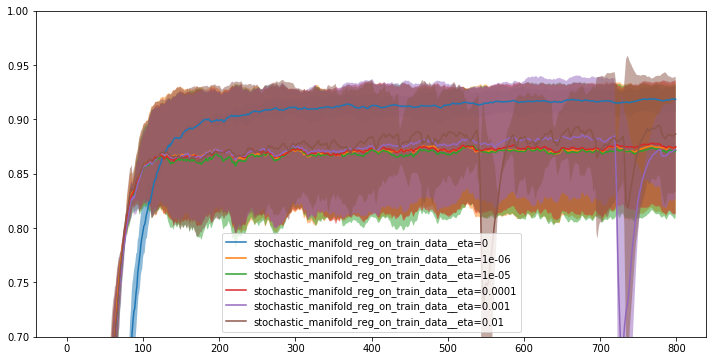

In [26]:
plt.figure(figsize=(12, 6))

alpha = 0.1
for mode in modes:
    curve = DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean()
    plt.plot(curve.mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        curve.mean(axis=0) - curve.std(axis=0),
        curve.mean(axis=0) + curve.std(axis=0),
        alpha=0.5
    )
plt.ylim(0.7, 1.0)
plt.legend(modes)

In [27]:
for mode in modes:
    print('{}: {:.2f} +- {:.2f}'.format(
        mode, 
        DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean().mean(axis=0).max() * 100, 
        DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean().std(axis=0)[
            np.argmax(DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean().mean(axis=0))
        ] * 100, 
    ))

stochastic_manifold_reg_on_train_data__eta=0: 91.89 +- 1.12
stochastic_manifold_reg_on_train_data__eta=1e-06: 87.60 +- 5.80
stochastic_manifold_reg_on_train_data__eta=1e-05: 87.61 +- 5.22
stochastic_manifold_reg_on_train_data__eta=0.0001: 87.80 +- 5.61
stochastic_manifold_reg_on_train_data__eta=0.001: 88.58 +- 5.26
stochastic_manifold_reg_on_train_data__eta=0.01: 89.45 +- 4.56
